In [3]:
import sys
import os 

repo_root = os.path.abspath('..')
sys.path.append(repo_root)

from src.utils.database_manager import DatabaseManager
from src.models import tf_idf

import math
from math import log
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd 
import contextily as ctx
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler




In [4]:
plt.rc('font', family='Serif', size=12)
plt.rc('axes', titlesize=14, titleweight='bold')
plt.rc('axes', labelsize=12, titlesize=14)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## load and clean data

In [5]:
def retrieve_combined_dataset(city, state_abbr):
    db_manager = DatabaseManager('../apf.db')

    amenities_df = db_manager.retrieve_amenities(city, state_abbr)
    tf_idf_df = tf_idf.get_tf(amenities_df)
    unit_df = db_manager.retrieve_units(city, state_abbr)
    merged_df = pd.merge(tf_idf_df, unit_df, on='UnitId', how='left')
    merged_df['Neighborhood'].replace('', 'Unknown', inplace=True)

    return merged_df

In [6]:
city = 'chicago'
state_abbr = 'il'


In [7]:

df = retrieve_combined_dataset(city, state_abbr)

3


/tmp/ipykernel_13851/1047033042.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Neighborhood'].replace('', 'Unknown', inplace=True)


In [8]:
main_data = df[['Latitude','Longitude','Neighborhood','RentPrice','Beds','Baths','SquareFootage']]
main_data = main_data[main_data['RentPrice'].notna()]

lower_cap = main_data['RentPrice'].quantile(0.00)
upper_cap = main_data['RentPrice'].quantile(0.995)
main_data['RentPrice'] = main_data['RentPrice'].clip(lower_cap, upper_cap)

## General Statistics 

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): print(main_data.describe())


           Latitude     Longitude     RentPrice          Beds         Baths  \
count  18780.000000  18780.000000  18789.000000  18789.000000  18789.000000   
mean      41.897480    -87.645691   2721.928639      1.170525      1.310660   
std        0.051312      0.038141   1376.244218      0.968463      0.585634   
min       41.630430    -87.954420    495.000000      0.000000      0.000000   
25%       41.876380    -87.655140   1868.000000      0.000000      1.000000   
50%       41.890560    -87.640440   2482.000000      1.000000      1.000000   
75%       41.916927    -87.625910   3172.000000      2.000000      2.000000   
max       42.035910    -87.529380  10400.300000      6.000000      9.000000   

       SquareFootage  
count   18376.000000  
mean      788.726437  
std       373.663411  
min         1.000000  
25%       570.000000  
50%       720.000000  
75%       935.000000  
max      9324.000000  


## Distributions of Rent Prices

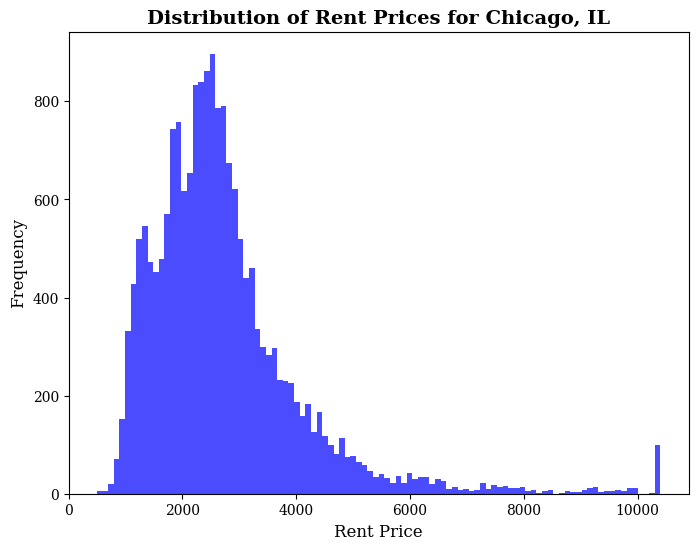

In [10]:

plt.figure(figsize=(8,6))
plt.hist(main_data['RentPrice'], bins=100, color='blue', alpha=0.7)
plt.title(f'Distribution of Rent Prices for {city.title()}, {state_abbr.upper()}')
plt.xlabel('Rent Price')
# plt.xscale('log')
plt.ylabel('Frequency')
plt.savefig('price_dist.png')
plt.show()

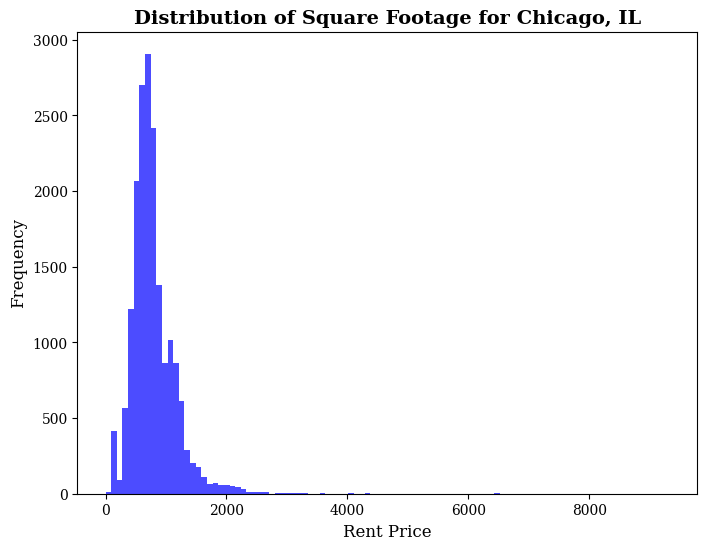

In [20]:

plt.figure(figsize=(8,6))
plt.hist(main_data['SquareFootage'], bins=100, color='blue', alpha=0.7)
plt.title(f'Distribution of Square Footage for {city.title()}, {state_abbr.upper()}')
plt.xlabel('Rent Price')
# plt.xscale('log')
plt.ylabel('Frequency')
plt.savefig('price_dist.png')
plt.show()

## Basic Linear Regression

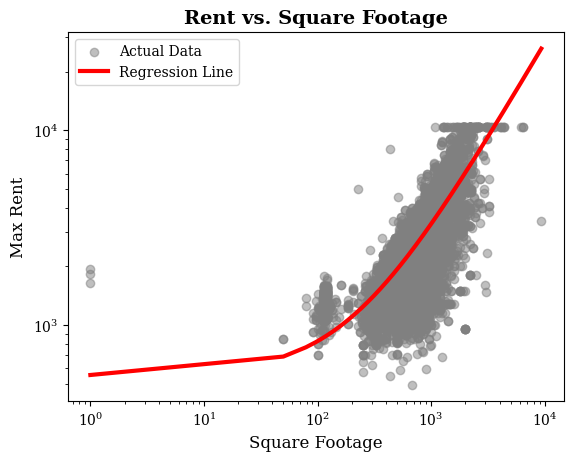

In [23]:
lin_regress_data = main_data[main_data['SquareFootage'].notna()].sort_values(by= ['SquareFootage'])

X = lin_regress_data[['SquareFootage']]
y = lin_regress_data['RentPrice']

# # Fit the model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

plt.scatter(lin_regress_data['SquareFootage'], lin_regress_data['RentPrice'], color='grey', alpha=0.5, label='Actual Data')
plt.plot(X, y_pred, color='red', linewidth=3, label='Regression Line')

# Labels and title
plt.xlabel('Square Footage')
plt.ylabel('Max Rent')
plt.yscale('log')
plt.xscale('log')
plt.title('Rent vs. Square Footage')
plt.legend()
plt.show()

### Pairplot

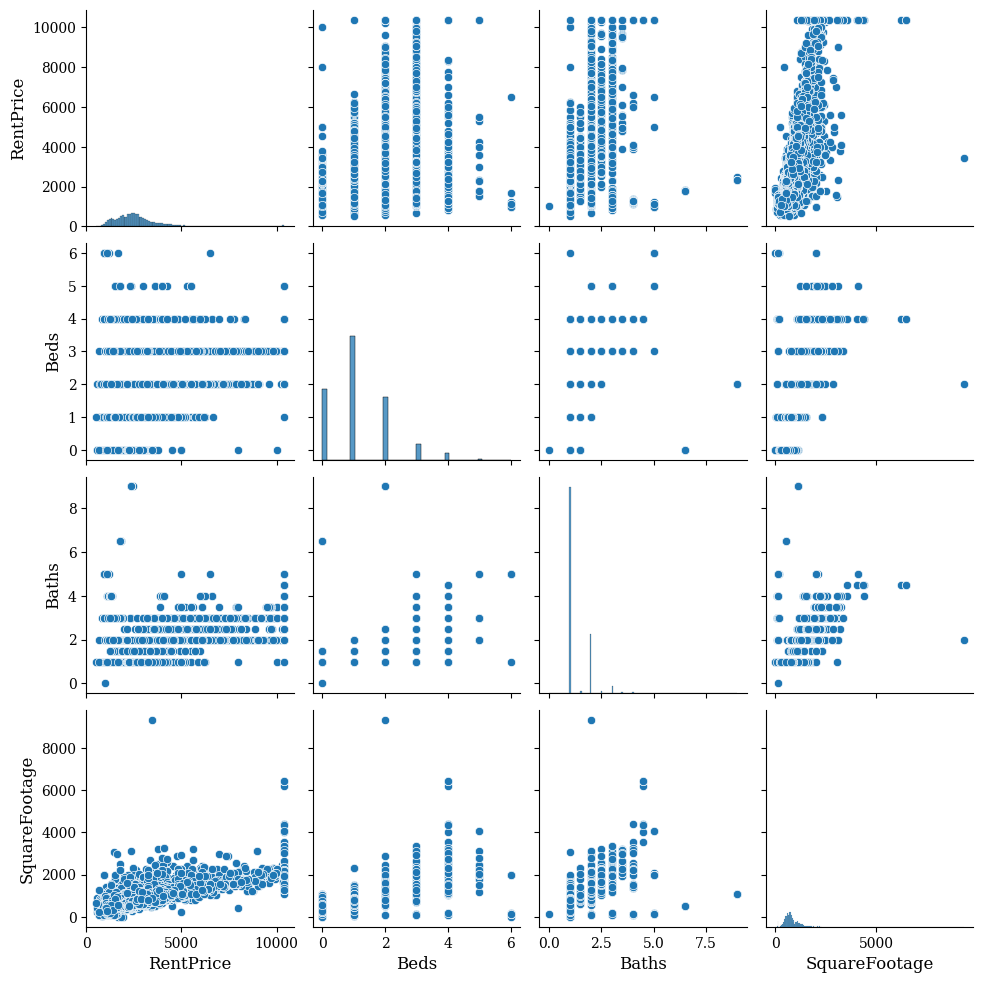

In [16]:
sns.pairplot(main_data.drop(columns=['Latitude', 'Longitude']))

## Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

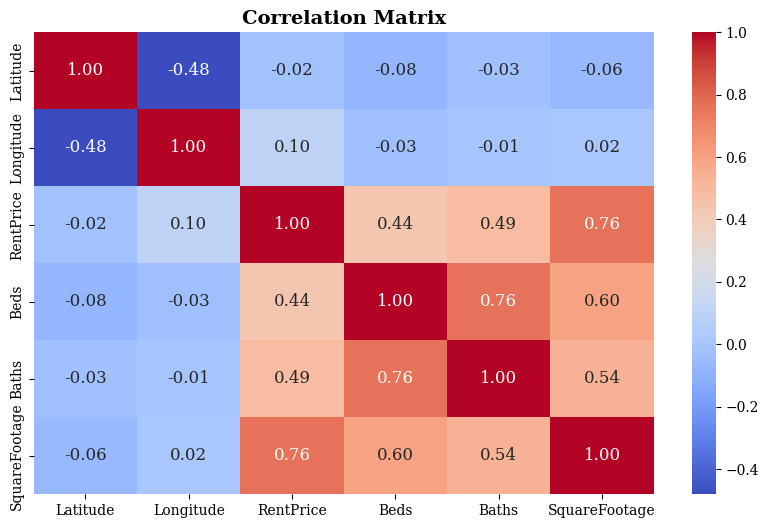

In [13]:
plt.figure(figsize=(10,6))
corr_matrix = main_data.drop(columns=['Neighborhood']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')


## Visual Mapping
Visualizing Neighborhoods based on rent and amount

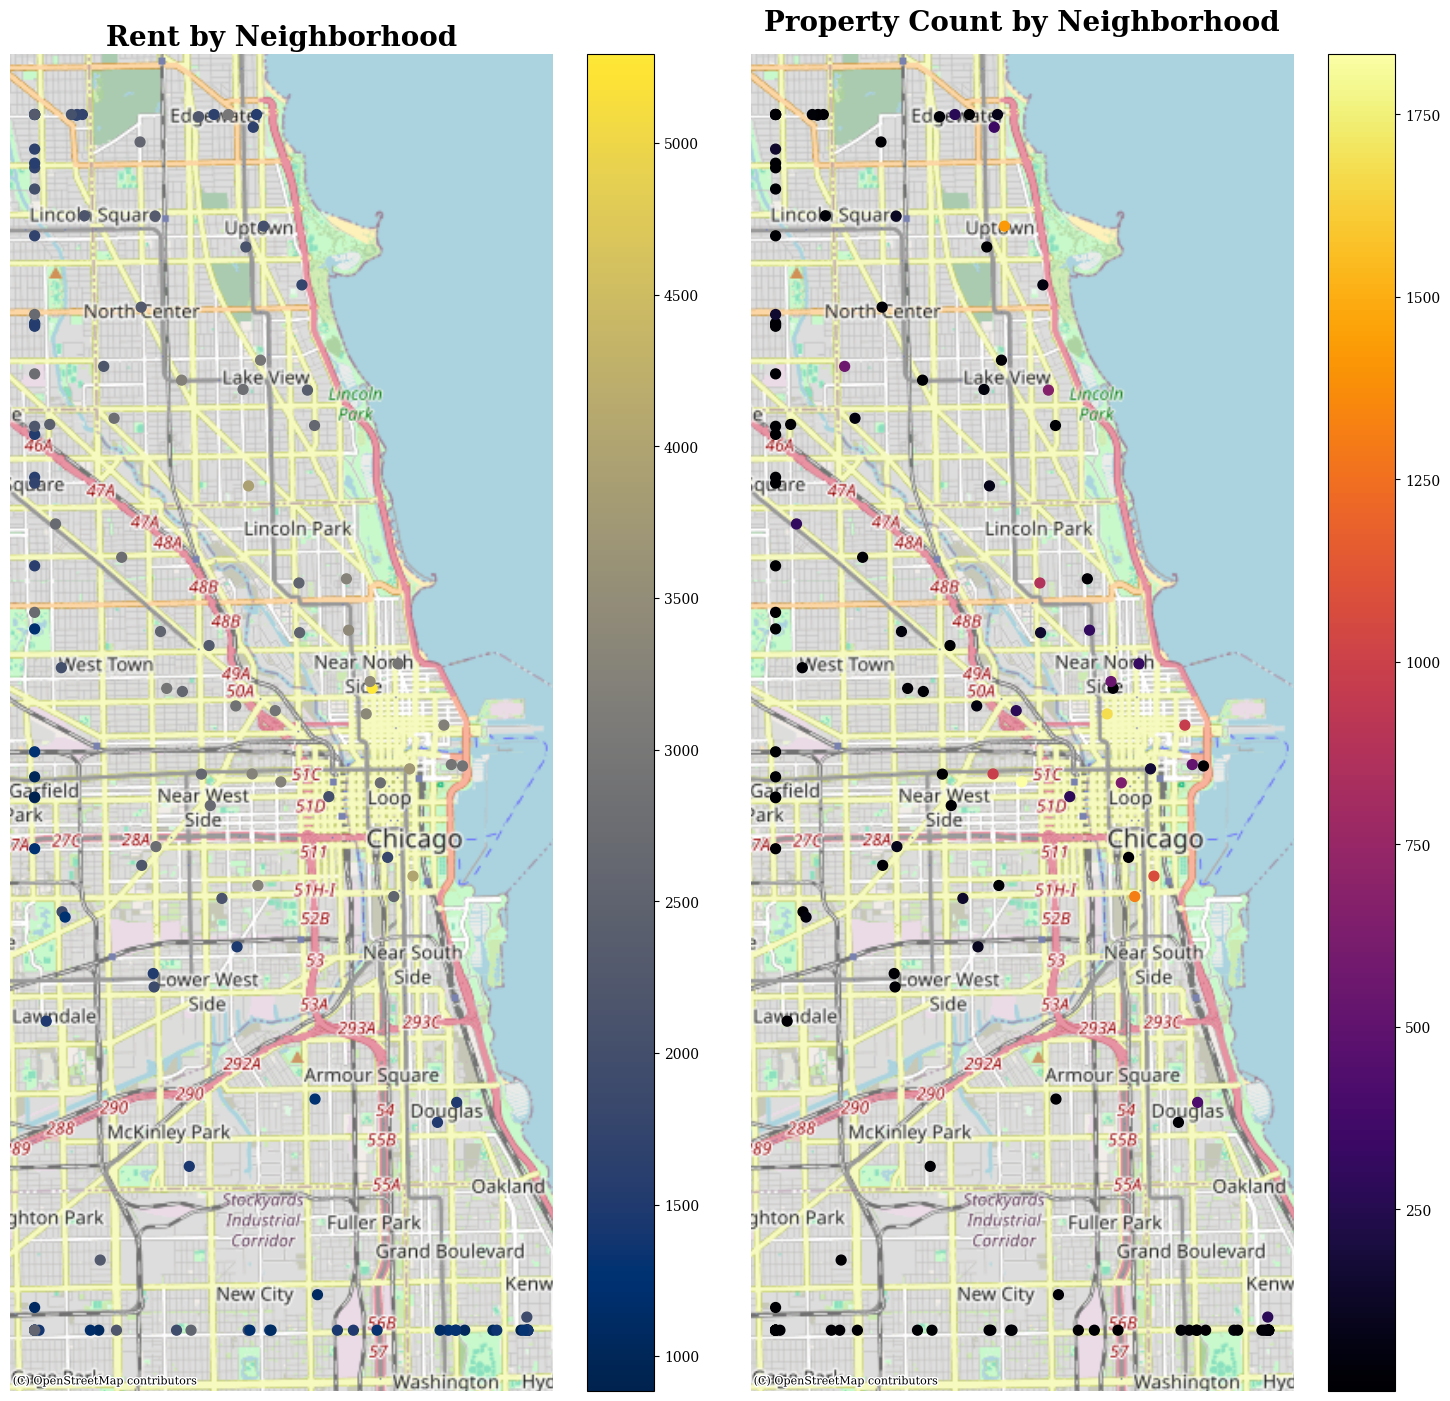

In [14]:
# Handle miscaculated lat long from addresses
lower_cap = main_data['Latitude'].quantile(0.05)
upper_cap = main_data['Latitude'].quantile(0.95)
main_data['Latitude'] = main_data['Latitude'].clip(lower_cap, upper_cap)

lower_cap = main_data['Longitude'].quantile(0.05)
upper_cap = main_data['Longitude'].quantile(0.95)
main_data['Longitude'] = main_data['Longitude'].clip(lower_cap, upper_cap)

# Get meta-data for neighborhoods
neighborhoods = main_data.groupby('Neighborhood').agg(
    MaxRent_Mean=('RentPrice', 'mean'),
    MaxRent_Std=('RentPrice', 'std'),
    Latitude_Mean=('Latitude', 'mean'),
    Longitude_Mean=('Longitude', 'mean'),
    Property_Count=('Neighborhood', 'size')
)

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(neighborhoods['Longitude_Mean'], neighborhoods['Latitude_Mean'])]
gdf = gpd.GeoDataFrame(neighborhoods, geometry=geometry)
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(epsg=3857)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 14))

# Plot 1: Heatmap based on MaxRent_Mean
gdf.plot(ax=ax1, marker='o', column='MaxRent_Mean', cmap='cividis', legend=True, markersize=50)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_axis_off()
ax1.set_title('Rent by Neighborhood', fontsize=20)

# Plot 2: Heatmap based on Property_Count
gdf.plot(ax=ax2, marker='o', column='Property_Count', cmap='inferno', legend=True, markersize=50)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_axis_off()
ax2.set_title('Property Count by Neighborhood', fontsize=20)


plt.tight_layout()
plt.savefig('mapping.png', dpi=400)
plt.show()

In [27]:
neighborhoods[['MaxRent_Mean', 'MaxRent_Std']].sort_values(by='MaxRent_Mean', ascending=False)

,MaxRent_Mean,MaxRent_Std
Neighborhood,,
Near North,5295.000000,NaN
Grant Park,4007.820503,2080.876702
DePaul,3921.148235,1801.112973
New East Side,3711.849721,1919.245939
Near North Side,3413.351201,1935.983798
...,...,...
Roseland,1042.000000,141.408392
Austin,997.000000,299.527406
East Chatham,971.111111,121.212050
